### Import Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import datetime
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 10, 7

from numpy import inf

In [2]:
df_d_p = pd.read_csv('depression_threads.csv') #metadata and sentiments of depression threads
df_s_p = pd.read_csv('suicidewatch_threads.csv') #metadata and sentiments of suicidewatch threads

df_d_p = df_d_p.drop('Unnamed: 0', axis = 1)
df_s_p = df_s_p.drop('Unnamed: 0', axis = 1)

In [3]:
df_d_p = df_d_p.drop(['p_id', 'p_timestamp'], axis = 1)
df_s_p = df_s_p.drop(['p_id', 'p_timestamp'], axis = 1)

df_d_p['subreddit'] = 0
df_s_p['subreddit'] = 1

In [5]:
df_f = pd.concat([df_d_p, df_s_p]) #join the two datasets for classification

### Classify with Metadata

In [268]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
%matplotlib inline


In [7]:
df_f = df_f.dropna()
df_f['direct_comments_proportion'][df_f['direct_comments_proportion'] == inf] = 1

#### Logistic Regression

In [297]:

df_train = df_f.sample(frac=0.8,random_state=11)
df_val = df_f.drop(df_train.index)

X_train = df_train.drop(['subreddit'],axis=1)
y_train = df_train['subreddit']
X_val= df_val.drop(['subreddit'],axis=1)
y_val = df_val['subreddit']


In [298]:
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler() 
  
X_train = sc.fit_transform(X_train) 
X_val = sc.transform(X_val) 


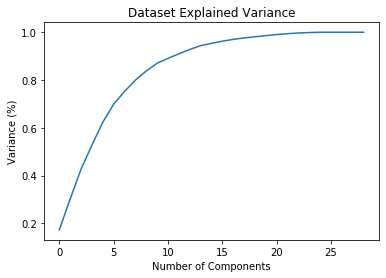

In [299]:
from sklearn.decomposition import PCA 
  
pca = PCA().fit(X_train)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance')
plt.show()

In [300]:
pca = PCA(n_components = 20)  #minimal loss in variance
  
X_train = pca.fit_transform(X_train) 
X_val = pca.transform(X_val) 

In [301]:
classifier = LogisticRegression(random_state = 11, class_weight='balanced') 
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_val)
y_pred_proba = classifier.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_pred)

print(confusion_matrix(y_pred, y_val))
print("Accuracy: ", accuracy_score(y_pred, y_val))

[[34 31]
 [10 62]]
Accuracy:  0.7007299270072993


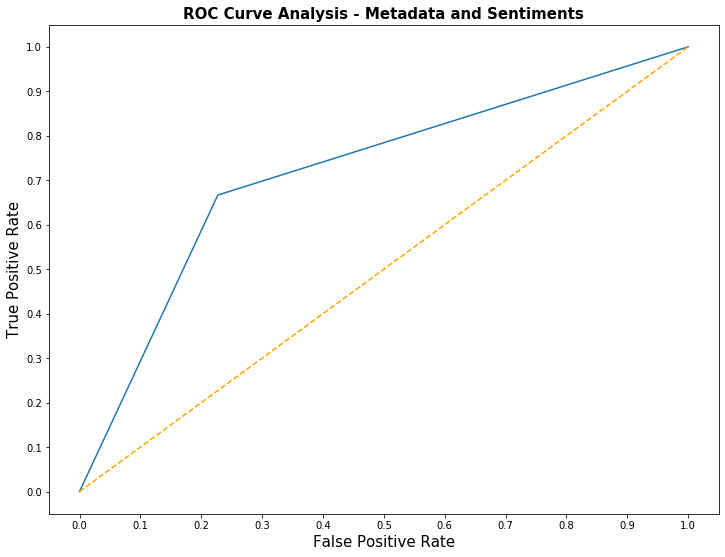

In [205]:
fig = plt.figure(figsize=(12,9))

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.show()

#### AdaBoost Classifier

In [303]:
X_train = df_train.drop(['subreddit'],axis=1)
y_train = df_train['subreddit']
X_val= df_val.drop(['subreddit'],axis=1)
y_val = df_val['subreddit']

X_train = sc.fit_transform(X_train) 
X_val = sc.transform(X_val) 

x = AdaBoostClassifier()
x.fit(X_train, y_train)
y_pred = x.predict(X_val)

y_pred_proba = x.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_pred)

print(confusion_matrix(y_pred, y_val))
print(accuracy_score(y_pred, y_val))

[[21 27]
 [23 66]]
0.635036496350365


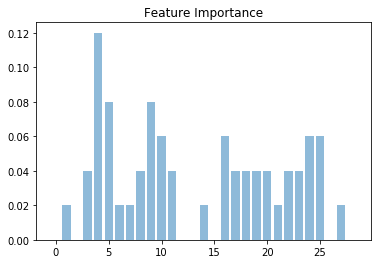

In [304]:
s = range(len(x.feature_importances_))

plt.bar(s, x.feature_importances_, align='center', alpha=0.5)
plt.title('Feature Importance')
plt.show()

In [283]:
df_train.drop(['subreddit'],axis=1).columns.values

array(['score', 'num_comments', 'direct_reply_comments',
       'direct_comments_proportion', 'median_direct_reply_time',
       'min_reply_time', 'P_Sent_Neg', 'P_Sent_Neu', 'P_Sent_Pos',
       'P_Sent_Com', 'median_comment_length', 'C_Sent_Neg', 'C_Sent_Neu',
       'C_Sent_Pos', 'C_Sent_Com', 'Diff_Sent_Neg', 'Diff_Sent_Neu',
       'Diff_Sent_Pos', 'Diff_Sent_Com', 'C_Neg_Feelings',
       'C_Suicide_Act', 'C_Goal', 'C_Medical', 'C_FPS', 'P_Neg_Feelings',
       'P_Suicide_Act', 'P_Goal', 'P_Medical', 'P_FPS'], dtype=object)

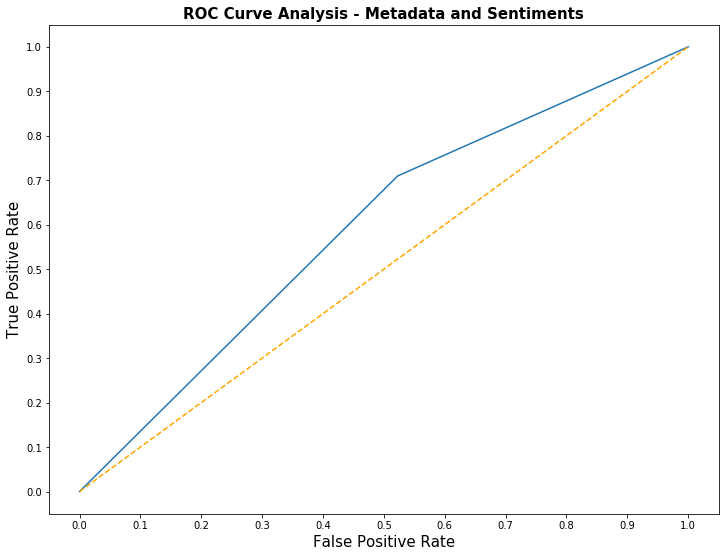

In [305]:
fig = plt.figure(figsize=(12,9))

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.show()

In [289]:
df_d_p.describe()

,score,num_comments,direct_reply_comments,direct_comments_proportion,median_direct_reply_time,min_reply_time,P_Sent_Neg,P_Sent_Neu,P_Sent_Pos,P_Sent_Com,...,C_Suicide_Act,C_Goal,C_Medical,C_FPS,P_Neg_Feelings,P_Suicide_Act,P_Goal,P_Medical,P_FPS,subreddit
count,934.000000,934.000000,604.000000,934.000000,604.000000,604.000000,934.000000,934.000000,934.000000,934.000000,...,934.000000,934.000000,934.000000,934.000000,934.000000,934.000000,934.000000,934.000000,934.000000,934.0
mean,15.298715,9.481799,3.907285,0.460554,181.817853,46.104939,0.220716,0.589676,0.189612,-0.170675,...,0.038837,0.073662,0.041672,0.044369,0.132414,0.094155,0.108392,0.094185,0.105572,0.0
std,99.307364,180.846732,19.433896,0.413204,1796.733370,98.500208,0.121447,0.133475,0.101575,0.737019,...,0.054137,0.084547,0.054615,0.058846,0.070771,0.062008,0.061532,0.059286,0.062170,0.0
min,0.000000,0.000000,1.000000,0.000000,0.500000,0.500000,0.000000,0.073000,0.000000,-0.996900,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,1.000000,0.000000,1.000000,0.000000,11.695833,4.795833,0.145250,0.512000,0.128250,-0.887850,...,0.000000,0.000000,0.000000,0.000000,0.091969,0.052175,0.069166,0.052632,0.066667,0.0
50%,2.000000,1.000000,2.000000,0.500000,31.725000,12.916667,0.211000,0.586000,0.184000,-0.401700,...,0.000000,0.055556,0.000000,0.000000,0.133660,0.095869,0.111111,0.097459,0.106159,0.0
75%,4.000000,4.000000,3.000000,1.000000,119.850000,40.925000,0.291750,0.659000,0.242750,0.598625,...,0.068415,0.129133,0.077630,0.083333,0.170631,0.131531,0.145889,0.132426,0.143947,0.0
max,1865.000000,5523.000000,443.000000,1.000000,43287.350000,1038.400000,0.821000,1.000000,0.706000,0.999100,...,0.500000,1.000000,0.500000,0.500000,0.666667,0.500000,0.500000,0.444444,0.444444,0.0


In [290]:
df_s_p.describe()

,score,num_comments,direct_reply_comments,direct_comments_proportion,median_direct_reply_time,min_reply_time,P_Sent_Neg,P_Sent_Neu,P_Sent_Pos,P_Sent_Com,...,C_Suicide_Act,C_Goal,C_Medical,C_FPS,P_Neg_Feelings,P_Suicide_Act,P_Goal,P_Medical,P_FPS,subreddit
count,980.000000,980.000000,832.000000,980.00,832.000000,832.000000,980.000000,980.000000,980.000000,980.000000,...,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.0
mean,12.339796,4.713265,2.668269,inf,444.235276,294.001783,0.231785,0.604958,0.161211,-0.332075,...,0.047721,0.099058,0.044729,0.053725,0.119383,0.094413,0.104228,0.088154,0.099718,1.0
std,56.005379,9.887954,5.223114,NaN,2104.680305,729.943574,0.146690,0.170250,0.122325,0.664773,...,0.060671,0.097973,0.060718,0.075615,0.080521,0.069610,0.076807,0.066711,0.071528,0.0
min,0.000000,0.000000,1.000000,0.00,0.583333,0.383333,0.000000,0.000000,0.000000,-0.999100,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,1.000000,1.000000,1.000000,0.25,18.760417,7.183333,0.140000,0.511000,0.082750,-0.936575,...,0.000000,0.000000,0.000000,0.000000,0.066667,0.038621,0.055556,0.030366,0.046378,1.0
50%,2.000000,2.000000,1.000000,0.50,60.841667,22.216667,0.233500,0.585000,0.156500,-0.595950,...,0.030989,0.090909,0.021739,0.031479,0.125000,0.098921,0.105263,0.093339,0.101868,1.0
75%,5.000000,5.000000,3.000000,1.00,232.633333,94.987500,0.315000,0.667250,0.220000,0.157250,...,0.079078,0.146187,0.074089,0.084639,0.164640,0.136204,0.145362,0.130435,0.142857,1.0
max,712.000000,157.000000,84.000000,inf,46355.975000,3345.950000,1.000000,1.000000,1.000000,0.995300,...,0.500000,1.000000,0.500000,1.000000,1.000000,0.500000,1.000000,0.500000,0.500000,1.0
